In [1]:
import sys, os, re, copy
import dill as pickle # this serializes all the functions inside the quantification dict
import numpy as np
import scipy as sp
from natsort import natsorted
from scipy.optimize import newton, minimize, fsolve
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib.ticker as tck
from matplotlib.gridspec import GridSpec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
palette = list(mcolors.TABLEAU_COLORS.keys())
#sns.set_theme(style="ticks", palette="muted")
sns.set_style("whitegrid")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("notebook", font_scale=1.5)

In [2]:
def impute_conc(piece_wise_fit_metab, response_ratio):
    '''
    This function imputes the concentration from a response ratio.
    '''
    response_ratio_range = np.array(list(piece_wise_fit_metab.keys()))
    mask_range = [response_ratio >= min_v and response_ratio <= max_v for max_v, min_v in response_ratio_range]
    k = tuple(response_ratio_range[mask_range][0])
    conc = piece_wise_fit_metab[k](response_ratio)
    estimator = 'intrapolation'
    if 0 in k:
        estimator = 'extrapolation under'
    elif np.inf in k:
        estimator = 'extrapolation over'
    return(conc, estimator)

# Calculate metabolite concentrations and merge with Asp-sensor signal

In [3]:
### Read quantification function ###
dict_pickle_fnam = 'AA_quant-dict.pickle'
with open(dict_pickle_fnam, 'rb') as handle:
    piece_wise_fit_quant = pickle.load(handle)

In [4]:
### Read measurements ###
### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('Asp-sens_steady-state_LCMS.xlsx', sheet_name=None)
annotation_df = pd.read_excel('Asp-sens_steady-state_LCMS-annotations.xlsx')
metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k])
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Area'] / metab_dict_mes[k]['ISTD Response']
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response Ratio'].fillna(0).replace(np.inf, 0)
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Filename', right_on='Filename')
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Flag Details', 'Filename', 'Type', 'RT', 'Sample ID'], axis=1)

In [5]:
### Impute concentration and add to metabolite dataframe ###
rr_mes = dict() # for plotting 
imp_conc_mes = dict() # for plotting
for metab in metab_names_mes[:]:
    # Assign imputed concentration:
    if metab in piece_wise_fit_quant:
        conc_list = list()
        estimator_list = list()
        for rr in metab_dict_mes[metab]['Response Ratio'].values:
            conc, estimator = impute_conc(piece_wise_fit_quant[metab], rr)
            conc_list.append(conc)
            estimator_list.append(estimator)
        metab_dict_mes[metab]['imputed_sample_conc'] = conc_list
        metab_dict_mes[metab]['imputed_sample_conc'] = metab_dict_mes[metab]['imputed_sample_conc'] / metab_dict_mes[metab]['dilution']
        metab_dict_mes[metab]['imputed_sample_estimator'] = estimator_list

In [6]:
# Generate dataframe for concentrations and estimtors:
print_cols = ['Sample_name', 'Cell line', 'Drug', 'Conc (nM)', 'Rescue', 'IC_well', 'GFP', 'RFP', 'GFP/RFP']
conc_df = metab_dict_mes['Glutamine pos'].loc[:, print_cols]
est_df = metab_dict_mes['Glutamine pos'].loc[:, print_cols]

for metab_nam in metab_dict_mes:
    if 'imputed_sample_conc' in metab_dict_mes[metab_nam].columns:
        conc_df = conc_df.merge(metab_dict_mes[metab_nam].loc[:, ['Sample_name', 'imputed_sample_conc']], on='Sample_name')
        conc_df = conc_df.rename(columns={'imputed_sample_conc': metab_nam})
        est_df = est_df.merge(metab_dict_mes[metab_nam].loc[:, ['Sample_name', 'imputed_sample_estimator']], on='Sample_name')
        est_df = est_df.rename(columns={'imputed_sample_estimator': metab_nam})
    elif sum(metab_dict_mes[metab_nam]['Response Ratio']) > 0:
        conc_df = conc_df.merge(metab_dict_mes[metab_nam].loc[:, ['Sample_name', 'Response Ratio']], on='Sample_name')
        conc_df = conc_df.rename(columns={'Response Ratio': metab_nam})
        est_df[metab_nam] = 'Response Ratio'
    else:
        conc_df = conc_df.merge(metab_dict_mes[metab_nam].loc[:, ['Sample_name', 'Area']], on='Sample_name')
        conc_df = conc_df.rename(columns={'Area': metab_nam})
        est_df[metab_nam] = 'Peak area'

# Write to Excel file:
with pd.ExcelWriter('Asp-sens_steady-state_LCMS_conc.xlsx') as writer:  
    conc_df.to_excel(writer, sheet_name='metab')
    est_df.to_excel(writer, sheet_name='estimator')

# Plot relationship between LCMS measured metabolite concentration and Asp-sensor signal

In [7]:
### Sigmoidal fit of the Asp-sensor signal 
### as a function of absolute Asp concentration
def sig_fit(x, top, midpoint, bottom, slope):
    return(top + (bottom - top) / (1 + (x / midpoint)**slope))

def x_XX(top, midpoint, bottom, slope, XX):
    yXX = (top - bottom)*(100-XX)/100 + bottom
    mid = (midpoint * ((top - yXX) / (yXX - bottom))**(1.0 / slope))
    return(mid)

def sig_fit_loss(mes_y, x, p):
    pred_y = sig_fit(x, p[0], p[1], p[2], p[3])
    return(sum((mes_y-pred_y)**2))

def fit_sigmoid(x, y , percentiles, Ngrid, max_top):
    bnds = ((0, max_top), (0.01, None), (0, None), (0, None))
    def fun_sig_fit(p): return(sig_fit_loss(y, x, p))
    p_sig_fit = minimize(fun_sig_fit, (10, 5, 0, 1), method='L-BFGS-B', bounds=bnds)
    top, midpoint, bottom, slope = p_sig_fit.x
    # print(slope)

    x_lower = x_XX(top, midpoint, bottom, slope, percentiles[0])
    x_upper = x_XX(top, midpoint, bottom, slope, percentiles[1])
    x_sig = np.logspace(np.log10(x_lower), np.log10(x_upper), Ngrid, base=10)
    y_sig = sig_fit(x_sig, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2], p_sig_fit.x[3])
    x50 = x_XX(top, midpoint, bottom, slope, 50)
    
    return(x_sig, y_sig, x50, bottom, top)

def plot_sigmoid(x, y, ax1, max_top=None, percentile=(1, 99)):
    x_sig, y_sig, x50, bottom, top = fit_sigmoid(x, y, percentile, 1000, max_top)
    ax1.plot(x_sig, y_sig, color='black', linewidth=1)
    ax1.vlines(x50, bottom, top, ls='--', color='r')
    halfmax = round(x50)
    anno_str = 'GFP/RFP half-max\n{} μM'.format(halfmax)
    props = dict(boxstyle='round', alpha=1, \
                 ec=(1., 0.5, 0.5), \
                 fc=(1., 0.8, 0.8), \
                 )
    if percentile[1] < 96:
        ax1.text(0.55, 0.4, anno_str, transform=ax1.transAxes, fontsize=10,
                 va="top", multialignment='center', \
                 bbox=props)
    else:
        ax1.text(0.55, 0.4, anno_str, transform=ax1.transAxes, fontsize=10,
                 va="top", multialignment='center', \
                 bbox=props)


In [8]:
conc_res = list()
for c, r in zip(conc_df['Conc (nM)'], conc_df['Rescue']):
    if int(c) == c:
        if r != 'None':
            conc_res.append('{} + Pyr'.format(int(c)))
        else:
            conc_res.append('{}'.format(int(c)))
    else:
        if r != 'None':
            conc_res.append('{} + Pyr'.format(c))
        else:
            conc_res.append('{}'.format(c))
conc_df['conc_res'] = conc_res

conc_drug = list()
for c, r in zip(conc_df['conc_res'], conc_df['Drug']):
    if r != 'None':
        conc_drug.append('{} + {}'.format(c, r))
    else:
        conc_drug.append('{}'.format(c))
conc_df['conc_drug'] = conc_drug

In [9]:
conc_df[conc_df['Cell line'] == 'HT1080 Nuc-RFP Asp-sens']

Sample_name                Cell line       Drug  Conc (nM)    Rescue  \
24         C01  HT1080 Nuc-RFP Asp-sens   Rotenone        0.0      None   
25         C02  HT1080 Nuc-RFP Asp-sens   Rotenone       12.5      None   
26         C04  HT1080 Nuc-RFP Asp-sens   Rotenone       50.0      None   
27         C05  HT1080 Nuc-RFP Asp-sens   Rotenone      100.0      None   
28         C06  HT1080 Nuc-RFP Asp-sens   Rotenone      200.0      None   
29         C07  HT1080 Nuc-RFP Asp-sens   Rotenone        0.0      None   
30         C08  HT1080 Nuc-RFP Asp-sens   Rotenone       12.5      None   
31         C09  HT1080 Nuc-RFP Asp-sens   Rotenone       25.0      None   
32         C10  HT1080 Nuc-RFP Asp-sens   Rotenone       50.0      None   
33         C11  HT1080 Nuc-RFP Asp-sens   Rotenone      100.0      None   
34         C12  HT1080 Nuc-RFP Asp-sens   Rotenone      200.0      None   
35         C13  HT1080 Nuc-RFP Asp-sens   Rotenone        0.0      None   
36         C14  HT1080 Nuc-RFP Asp-sens   Rotenone       12.5      None   
37         C15  HT1080 Nuc-RFP Asp-sens   Rotenone       25.0      None   
38         C16  HT1080 Nuc-RFP Asp-sens   Rotenone       50.0      None   
39         C17  HT1080 Nuc-RFP Asp-sens   Rotenone      100.0      None   
40         C18  HT1080 Nuc-RFP Asp-sens   Rotenone      200.0      None   
41         D01  HT1080 Nuc-RFP Asp-sens  Metformin   500000.0      None   
42         D02  HT1080 Nuc-RFP Asp-sens  Metformin  1000000.0      None   
43         D03  HT1080 Nuc-RFP Asp-sens  Metformin  2000000.0      None   
44         D04  HT1080 Nuc-RFP Asp-sens  Metformin  4000000.0      None   
45         D05  HT1080 Nuc-RFP Asp-sens   Rotenone      200.0  2 mM Pyr   
46         D06  HT1080 Nuc-RFP Asp-sens  Metformin   500000.0      None   
47         D07  HT1080 Nuc-RFP Asp-sens  Metformin  1000000.0      None   
48         D08  HT1080 Nuc-RFP Asp-sens  Metformin  2000000.0      None   
49         D09  HT1080 Nuc-RFP Asp-sens  Metformin  4000000.0      None   
50         D10  HT1080 Nuc-RFP Asp-sens   Rotenone      200.0  2 mM Pyr   
51         D11  HT1080 Nuc-RFP Asp-sens  Metformin   500000.0      None   
52         D12  HT1080 Nuc-RFP Asp-sens  Metformin  1000000.0      None   
53         D13  HT1080 Nuc-RFP Asp-sens  Metformin  2000000.0      None   
54         D14  HT1080 Nuc-RFP Asp-sens  Metformin  4000000.0      None   
55         D15  HT1080 Nuc-RFP Asp-sens   Rotenone      200.0  2 mM Pyr   

   IC_well       GFP        RFP    GFP/RFP  Alanine pos  ...  Proline pos  \
24      D1  46679570  1647384.0  28.335573   565.938429  ...   594.944243   
25      A2  23647610  1678485.0  14.088663   608.666097  ...   526.613056   
26      A4   9762032  1285069.0   7.596504   856.591808  ...   749.610795   
27      A5   9767179  1313983.0   7.433261   981.824974  ...   853.748319   
28      A6  10034110  1403958.0   7.147016   923.820788  ...   759.684994   
29      B1  48198660  1667158.0  28.910673   521.519616  ...   582.617326   
30      B2  22950390  1781237.0  12.884524   567.119012  ...   539.401763   
31      B3  13455450  1514979.0   8.881608   613.306700  ...   568.443833   
32      B4   9039276  1286037.0   7.028784   947.500152  ...   895.805602   
33      B5   9394878  1396718.0   6.726396   823.624285  ...   746.195603   
34      B6  10488250  1415745.0   7.408290   863.579782  ...   753.365846   
35      C1  50619280  1809537.0  27.973609   527.345249  ...   604.551119   
36      C2  20374630  1703420.0  11.961014   491.110223  ...   461.439461   
37      C3  13002580  1522800.0   8.538600   629.234213  ...   560.184935   
38      C4   9437515  1242085.0   7.598123   861.147010  ...   808.586946   
39      C5   8291821  1186799.0   6.986710   783.329066  ...   722.553865   
40      C6  10633850  1483082.0   7.170103   852.315729  ...   735.005090   
41      A1  38330300  1240045.0  30.910411   724.315055  ...   681.800002   
42      A2  22518110  1133226.0  19.870802   759.957435  ...   6

### Plots for 293t

In [10]:
mask = conc_df['Cell line'] == '293t Asp-sens-RFP'
plot_order = natsorted(conc_df.loc[mask, 'conc_res'])

metab_list = ['Aspartate neg', 'Asparagine pos', 'Glutamate neg', 'Glutamine pos', 'Rotenone pos']
with PdfPages('steady-state_plots/steady-state_293t_Asp-sens-RFP.pdf') as pp:
    for metab in metab_list:
        metab_nam = metab.split()[0]
        fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))
        
        if metab_nam == 'Aspartate':
            y = conc_df.loc[mask, 'GFP/RFP']
            x = conc_df.loc[mask, 'Aspartate neg'].values
            plot_sigmoid(x, y, ax1, max_top=max(y)*1.2)
        else:
            g1 = sns.regplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, lowess=True, scatter_kws=dict(alpha=0))

        g2 = sns.scatterplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, hue='conc_res', zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, legend=True);
        g2.set_xscale('log', base=10)
        g2.set_ylabel('GFP/RFP (AU)')
        g2.set_xlabel('{} (µM)'.format(metab_nam))
        g2.set_title('293t')
        #g2.set_xticklabels(g1.get_xticklabels(), rotation=90, size=12)
        sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                        alignment='center', labelspacing=0.3, handletextpad=0.2, borderaxespad=0, \
                        handlelength=1, title='Rot (nM)', fontsize=12, title_fontsize=15)

        ax1.tick_params(which="both", bottom=True, labelrotation=25)
        pp.savefig(fig, bbox_inches='tight')
        plt.close(fig)

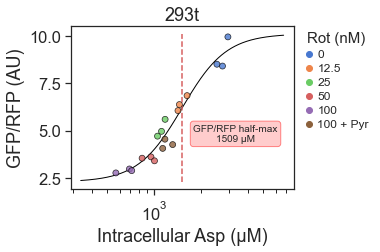

In [11]:
mask = conc_df['Cell line'] == '293t Asp-sens-RFP'
plot_order = natsorted(conc_df.loc[mask, 'conc_res'])

# metab_list = ['Aspartate neg', 'Glutamate neg']
metab_list = ['Aspartate neg']
with PdfPages('steady-state_plots/steady-state_293t_Asp-sens-RFP_Asp-Glu.pdf') as pp:
    for metab in metab_list:
        metab_nam = metab.split()[0]
        fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))
        
        if metab_nam == 'Aspartate':
            y = conc_df.loc[mask, 'GFP/RFP']
            x = conc_df.loc[mask, 'Aspartate neg'].values
            plot_sigmoid(x, y, ax1, max_top=max(y)*1.2)
        else:
            g1 = sns.regplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, lowess=True, scatter_kws=dict(alpha=0), line_kws=dict(color='black', linewidth=1))

        g2 = sns.scatterplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, hue='conc_res', zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, legend=True);
        g2.set_xscale('log', base=10)
        g2.set_ylabel('GFP/RFP (AU)')
        g2.set_xlabel('Intracellular {} (µM)'.format(metab_nam[0:3]))
        g2.set_title('293t')
        #g2.set_xticklabels(g1.get_xticklabels(), rotation=90, size=12)
        sns.move_legend(g2, "upper left", bbox_to_anchor=(1.02, 1), frameon=False, ncol=1, \
                        alignment='center', labelspacing=0.3, handletextpad=0.2, borderaxespad=0, \
                        handlelength=1, title='Rot (nM)', fontsize=12, title_fontsize=15)

        if metab_nam == 'Glutamate':
            ax1.tick_params(axis='x', which="both", bottom=True, labelrotation=25)
        pp.savefig(fig, bbox_inches='tight')
        #plt.close(fig)

### Plots for HT1080

In [12]:
mask = conc_df['Cell line'] == 'HT1080 Nuc-RFP Asp-sens'
plot_order = natsorted(conc_df.loc[mask, 'conc_res'])

metab_list = ['Aspartate neg', 'Asparagine pos', 'Glutamate neg', 'Glutamine pos', 'Rotenone pos', 'Metformin pos']
with PdfPages('steady-state_plots/steady-state_HT1080_Nuc-RFP_Asp-sens.pdf') as pp:
    for metab in metab_list:
        metab_nam = metab.split()[0]
        for drug in ['rot', 'met', 'both']:
            fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))
            mask_rot = mask & (conc_df['Drug'] == 'Rotenone')
            mask_met = mask & (conc_df['Drug'] == 'Metformin')

            if drug == 'both':
                if metab_nam == 'Aspartate':
                    y = conc_df.loc[mask, 'GFP/RFP']
                    x = conc_df.loc[mask, 'Aspartate neg'].values
                    plot_sigmoid(x, y, ax1, max_top=max(y)*1.2)
                else:
                    g1 = sns.regplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, lowess=True, scatter_kws=dict(alpha=0))
            elif drug == 'rot':
                if metab_nam == 'Aspartate':
                    y = conc_df.loc[mask_rot, 'GFP/RFP']
                    x = conc_df.loc[mask_rot, 'Aspartate neg'].values
                    plot_sigmoid(x, y, ax1, max_top=max(y)*1.2)
                else:
                    g1 = sns.regplot(ax=ax1, data=conc_df[mask_rot], y='GFP/RFP', x=metab, lowess=True, scatter_kws=dict(alpha=0))
            elif drug == 'met':
                if metab_nam == 'Aspartate':
                    y = conc_df.loc[mask_met, 'GFP/RFP']
                    x = conc_df.loc[mask_met, 'Aspartate neg'].values
                    plot_sigmoid(x, y, ax1, max_top=max(y)*1.2)
                else:
                    g1 = sns.regplot(ax=ax1, data=conc_df[mask_met], y='GFP/RFP', x=metab, lowess=True, scatter_kws=dict(alpha=0))

            if drug == 'rot' or drug == 'both':
                g2 = sns.scatterplot(ax=ax1, data=conc_df[mask_rot], y='GFP/RFP', x=metab, hue='conc_res', zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, legend=True, marker='X');
            if drug == 'met' or drug == 'both':
                g3 = sns.scatterplot(ax=ax1, data=conc_df[mask_met], y='GFP/RFP', x=metab, hue='conc_res', zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, legend=True, marker='d');


            g2.set_xscale('log', base=10)
            ax1.set_xscale('log', base=10)
            g2.set_ylabel('GFP/Nuc-RFP (AU)')
            g2.set_xlabel('{} (µM)'.format(metab_nam))
            g2.set_title('HT1080')
            #g2.set_xticklabels(g1.get_xticklabels(), rotation=90, size=12)

            if drug == 'both':
                sns.move_legend(g3, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=2, \
                                alignment='center', labelspacing=0.3, handletextpad=0.2, borderaxespad=0, \
                                handlelength=1, title='Rot/Met (nM)', fontsize=12, title_fontsize=15)
            elif drug == 'rot':
                sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                                alignment='center', labelspacing=0.3, handletextpad=0.2, borderaxespad=0, \
                                handlelength=1, title='Rot (nM)', fontsize=12, title_fontsize=15)
            elif drug == 'met':
                sns.move_legend(g3, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                                alignment='center', labelspacing=0.3, handletextpad=0.2, borderaxespad=0, \
                                handlelength=1, title='Met (nM)', fontsize=12, title_fontsize=15)

            ax1.tick_params(which="both", bottom=True, labelrotation=25)

            pp.savefig(fig, bbox_inches='tight')
            plt.close(fig)

/Users/krdav/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
<ipython-input-12-beb66376420c>:42: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.set_xscale('log', base=10)


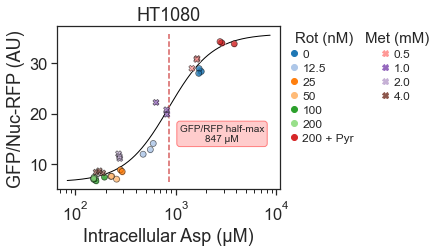

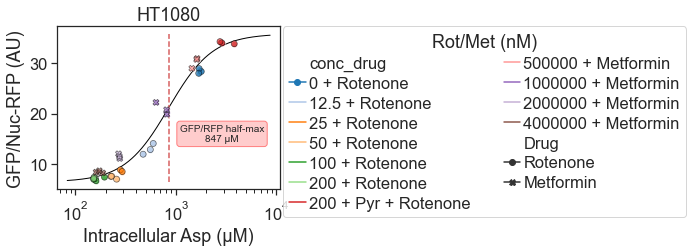

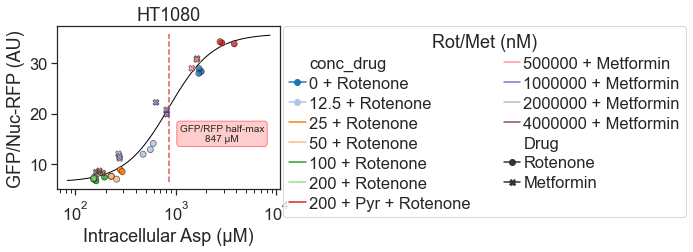

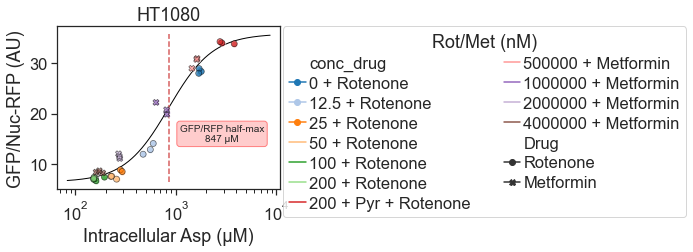

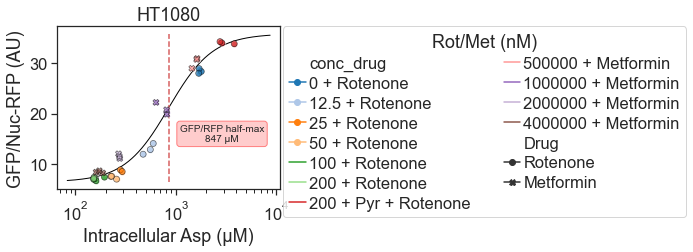

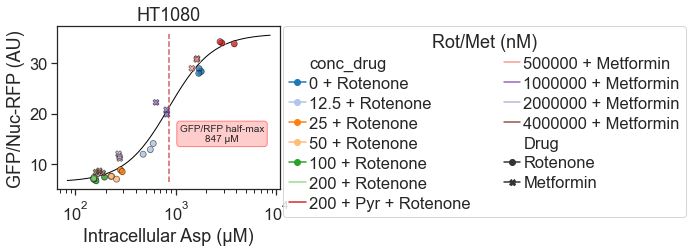

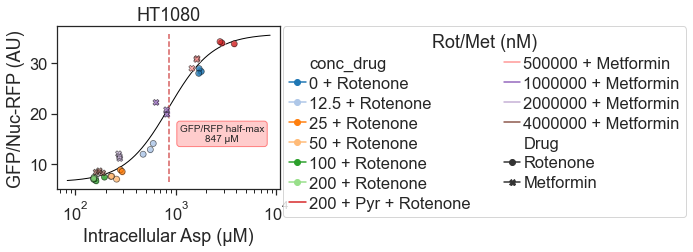

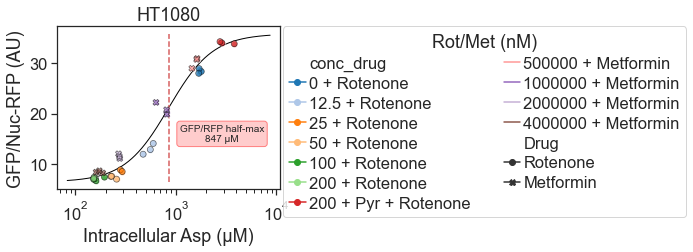

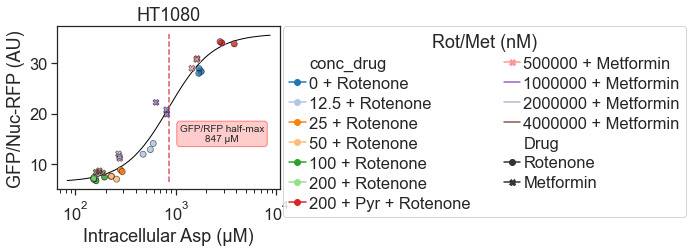

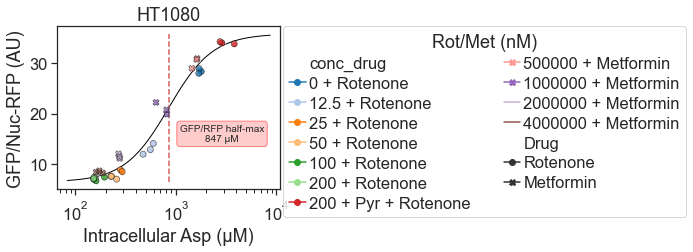

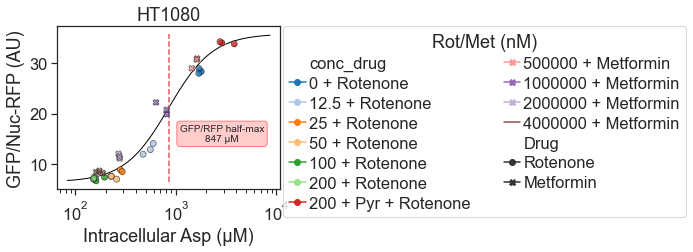

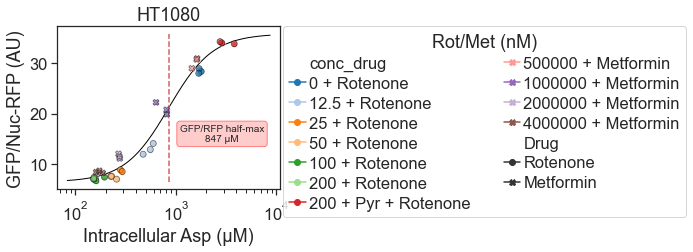

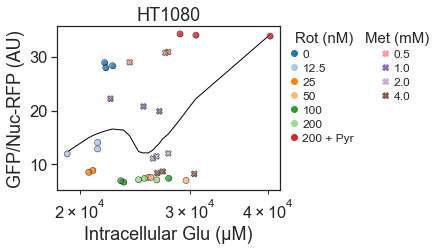

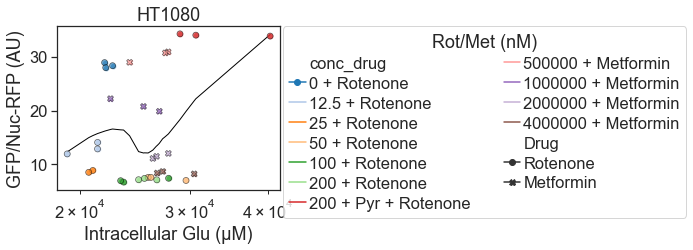

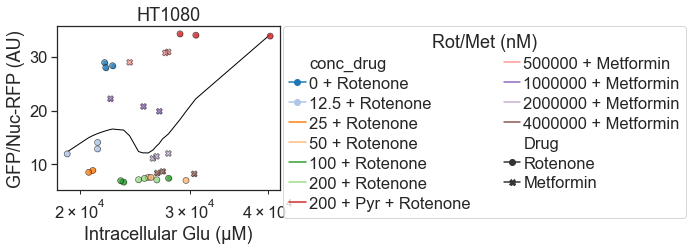

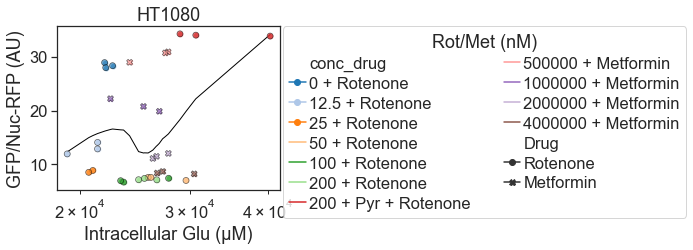

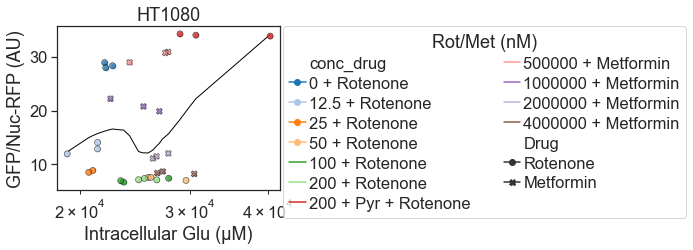

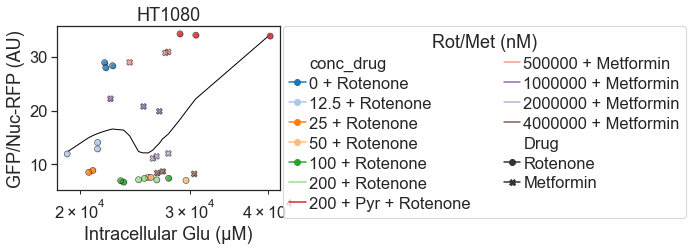

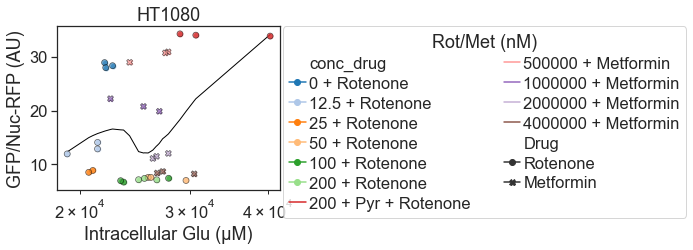

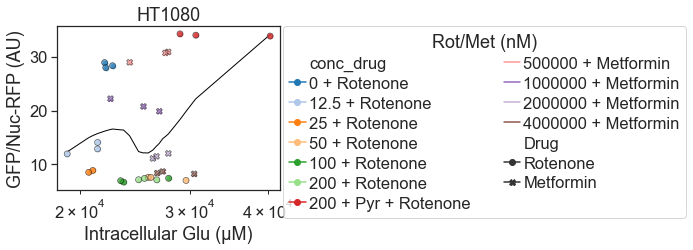

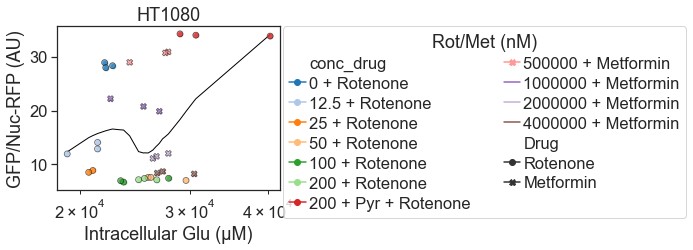

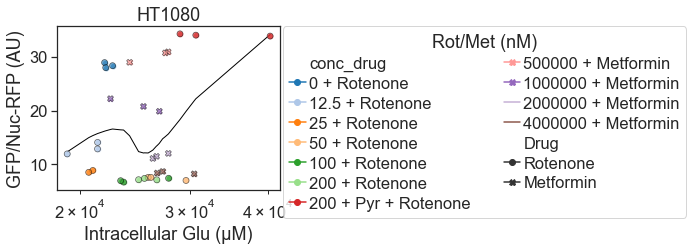

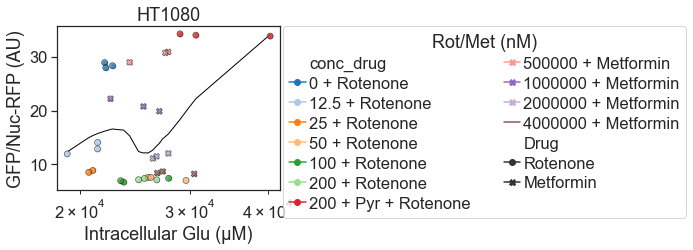

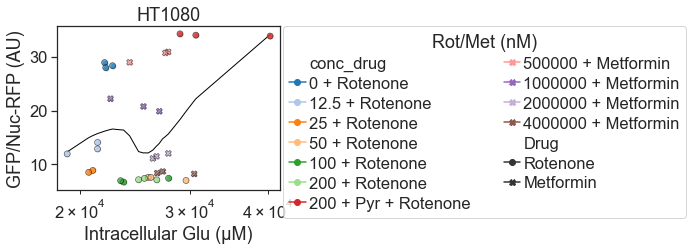

In [13]:
mask = conc_df['Cell line'] == 'HT1080 Nuc-RFP Asp-sens'
# hue_order = natsorted(conc_df.loc[mask, 'conc_drug'])
hue_order = ['0 + Rotenone',
 '12.5 + Rotenone',
 '25 + Rotenone',
 '50 + Rotenone',
 '100 + Rotenone',
 '200 + Rotenone',
 '200 + Pyr + Rotenone',
 '500000 + Metformin',
 '1000000 + Metformin',
 '2000000 + Metformin',
 '4000000 + Metformin']
style_order = ['Rotenone', 'Metformin']

metab_list = ['Aspartate neg', 'Glutamate neg']
with PdfPages('steady-state_plots/steady-state_HT1080_Nuc-RFP_Asp-sens_Asp-Glu.pdf') as pp:
    for metab in metab_list:
        metab_nam = metab.split()[0]
        
        fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))
        if metab_nam == 'Aspartate':
            y = conc_df.loc[mask, 'GFP/RFP']
            x = conc_df.loc[mask, 'Aspartate neg'].values
            plot_sigmoid(x, y, ax1, max_top=max(y)*1.2)
        else:
            g1 = sns.regplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, lowess=True, scatter_kws=dict(alpha=0), line_kws=dict(color='black', linewidth=1))

        g2 = sns.lineplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, hue='conc_drug', \
                             hue_order=hue_order, zorder=10, alpha=0.6, \
                             legend=True, markers=True, style='Drug', style_order=style_order, \
                             ls='none', dashes=False, palette='tab20');
        g3 = sns.scatterplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, hue='conc_drug', \
                             hue_order=hue_order, zorder=10, edgecolor='black', linewidth=0.7, alpha=0.6, \
                             legend=False, markers=True, style='Drug', style_order=style_order, palette='tab20');

        g2.set_xscale('log', base=10)
        ax1.set_xscale('log', base=10)
        g2.set_ylabel('GFP/Nuc-RFP (AU)')
        g2.set_xlabel('Intracellular {} (µM)'.format(metab_nam[0:3]))
        g2.set_title('HT1080')
        #g2.set_xticklabels(g1.get_xticklabels(), rotation=90, size=12)

        sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=2, \
                        alignment='center', labelspacing=0.3, handletextpad=0.2, borderaxespad=0, \
                        handlelength=1, title='Rot/Met (nM)')

        rot_lh, rot_lt = [], []
        met_lh, met_lt = [], []
        for lh in ax1.legend_.legendHandles:
            l_txt = lh.get_label().split(' + ')
            if len(l_txt) == 1:
                continue
            elif len(l_txt) == 3:
                l_txt = [l_txt[0]+' + '+l_txt[1], l_txt[2]]
                
            if 'Rotenone' in l_txt[1]:
                lh.set_marker('o')
                rot_lh.append(copy.deepcopy(lh))
                rot_lt.append(l_txt[0])
            elif 'Metformin' in l_txt[1]:
                lh.set_marker('X')
                met_lh.append(copy.deepcopy(lh))
                met_conc = str(int(l_txt[0])/1e6)
                met_lt.append(met_conc)

        l1 = ax1.legend(rot_lh, rot_lt, loc='upper left', bbox_to_anchor=(1.04, 1), frameon=False, ncol=1, \
                        alignment='center', labelspacing=0.3, handletextpad=0.7, borderaxespad=0, \
                        handlelength=0, title='Rot (nM)', fontsize=12, title_fontsize=15)
        l2 = ax1.legend(met_lh, met_lt, loc='upper left', bbox_to_anchor=(1.36, 1), frameon=False, ncol=1, \
                        alignment='center', labelspacing=0.3, handletextpad=0.7, borderaxespad=0, \
                        handlelength=0, title='Met (mM)', fontsize=12, title_fontsize=15)
        ax1.add_artist(l1)
        
        pp.savefig(fig, bbox_inches='tight')
        # plt.close(fig)

### Plots for H1299

In [14]:
mask = (conc_df['Cell line'] == 'H1299 Nuc-RFP Asp-sens') & (conc_df['Drug'] != 'AOA') & (conc_df['Drug'] != 'Antimycin A')
plot_order = natsorted(conc_df.loc[mask, 'conc_res'])

metab_list = ['Aspartate neg', 'Asparagine pos', 'Glutamate neg', 'Glutamine pos', 'Rotenone pos', 'Metformin pos']
with PdfPages('steady-state_plots/steady-state_H1299_Nuc-RFP_Asp-sens.pdf') as pp:
    for metab in metab_list:
        metab_nam = metab.split()[0]
        for drug in ['rot', 'met', 'both']:
            fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))
            mask_rot = mask & (conc_df['Drug'] == 'Rotenone')
            mask_met = mask & (conc_df['Drug'] == 'Metformin')

            if drug == 'both':
                if metab_nam == 'Aspartate':
                    y = conc_df.loc[mask, 'GFP/RFP']
                    x = conc_df.loc[mask, 'Aspartate neg'].values
                    plot_sigmoid(x, y, ax1, max_top=max(y)*1.2)
                else:
                    g1 = sns.regplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, lowess=True, scatter_kws=dict(alpha=0))
            elif drug == 'rot':
                if metab_nam == 'Aspartate':
                    y = conc_df.loc[mask_rot, 'GFP/RFP']
                    x = conc_df.loc[mask_rot, 'Aspartate neg'].values
                    plot_sigmoid(x, y, ax1, max_top=max(y)*1.2)
                else:
                    g1 = sns.regplot(ax=ax1, data=conc_df[mask_rot], y='GFP/RFP', x=metab, lowess=True, scatter_kws=dict(alpha=0))
            elif drug == 'met':
                if metab_nam == 'Aspartate':
                    y = conc_df.loc[mask_met, 'GFP/RFP']
                    x = conc_df.loc[mask_met, 'Aspartate neg'].values
                    plot_sigmoid(x, y, ax1, max_top=max(y)*1.2)
                else:
                    g1 = sns.regplot(ax=ax1, data=conc_df[mask_met], y='GFP/RFP', x=metab, lowess=True, scatter_kws=dict(alpha=0))

            if drug == 'rot' or drug == 'both':
                g2 = sns.scatterplot(ax=ax1, data=conc_df[mask_rot], y='GFP/RFP', x=metab, hue='conc_res', zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, legend=True, marker='X');
            if drug == 'met' or drug == 'both':
                g3 = sns.scatterplot(ax=ax1, data=conc_df[mask_met], y='GFP/RFP', x=metab, hue='conc_res', zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, legend=True, marker='d');


            g2.set_xscale('log', base=10)
            g2.set_ylabel('GFP/RFP (AU)')
            g2.set_xlabel('{} (µM)'.format(metab_nam))
            g2.set_title('H1299 Nuc-RFP Asp-sens')
            #g2.set_xticklabels(g1.get_xticklabels(), rotation=90, size=12)

            if drug == 'both':
                sns.move_legend(g3, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=2, \
                                alignment='center', labelspacing=0.3, handletextpad=0.2, borderaxespad=0, \
                                handlelength=1, title='Rot/Met (nM)', fontsize=12, title_fontsize=15)
            elif drug == 'rot':
                sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                                alignment='center', labelspacing=0.3, handletextpad=0.2, borderaxespad=0, \
                                handlelength=1, title='Rot (nM)', fontsize=12, title_fontsize=15)
            elif drug == 'met':
                sns.move_legend(g3, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                                alignment='center', labelspacing=0.3, handletextpad=0.2, borderaxespad=0, \
                                handlelength=1, title='Met (nM)', fontsize=12, title_fontsize=15)

            ax1.tick_params(which="both", bottom=True, labelrotation=25)

            pp.savefig(fig, bbox_inches='tight')
            plt.close(fig)

/Users/krdav/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


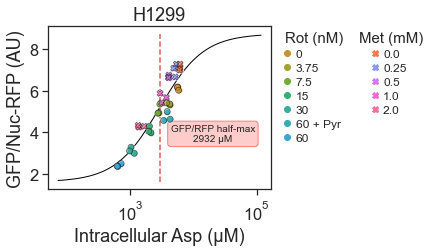

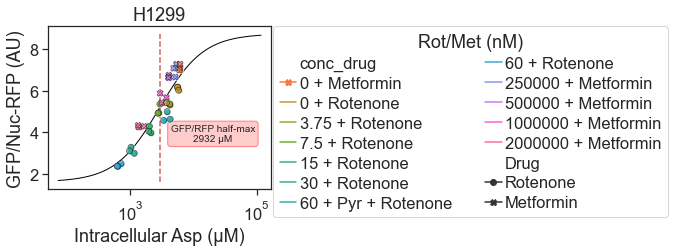

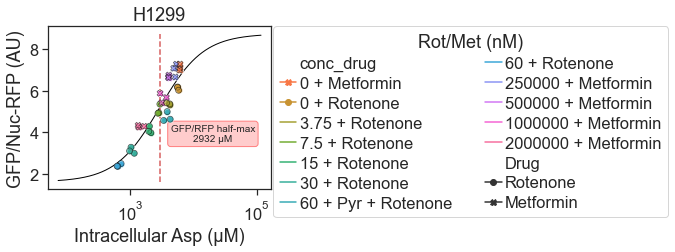

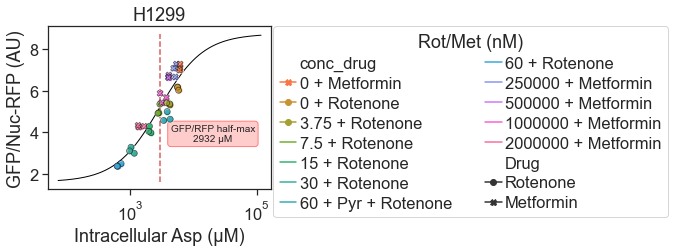

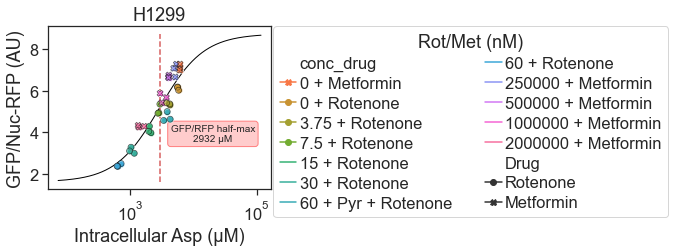

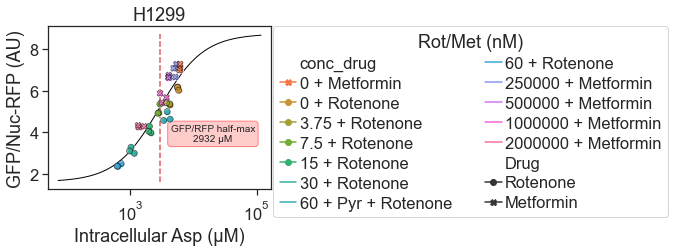

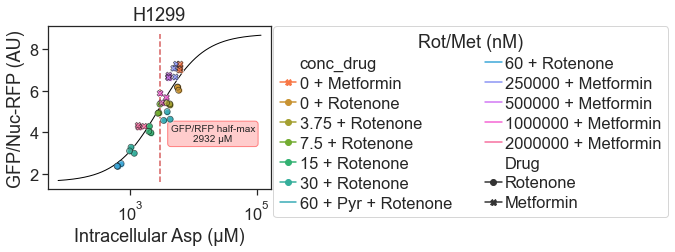

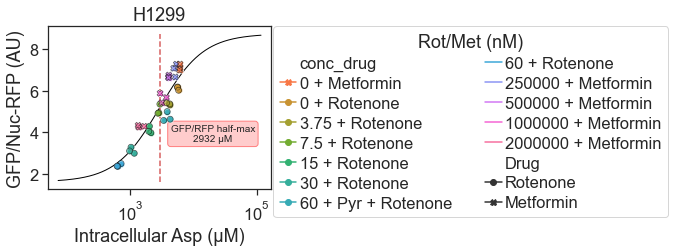

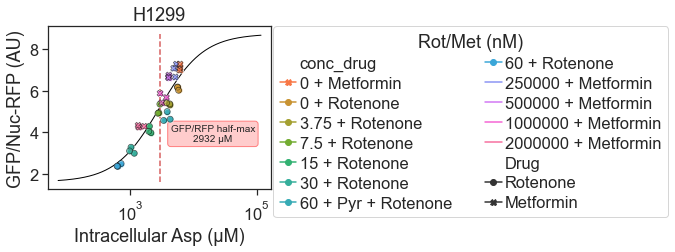

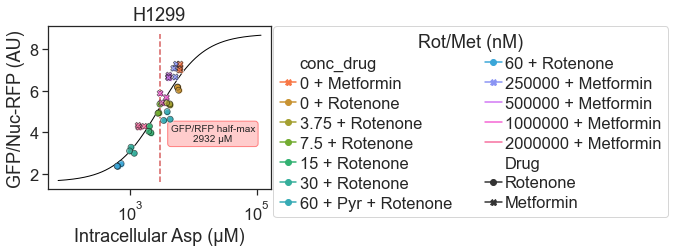

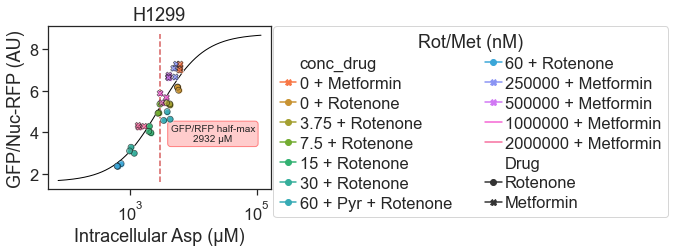

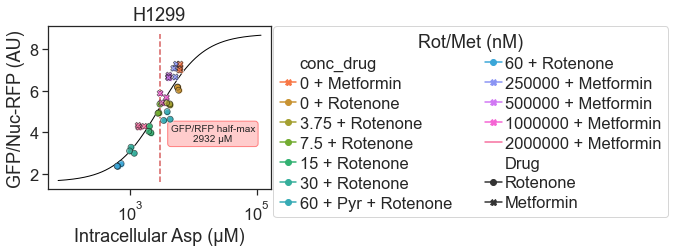

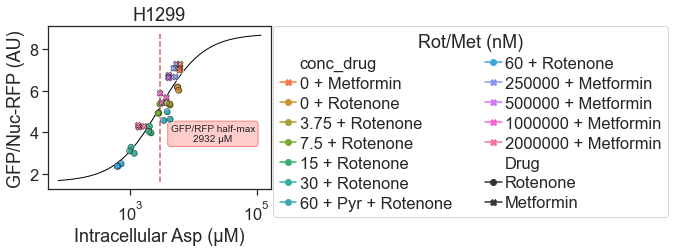

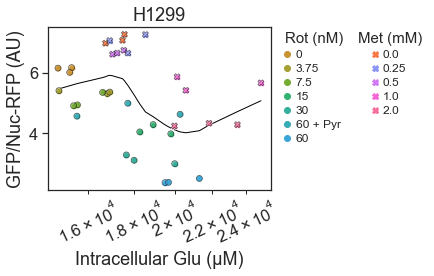

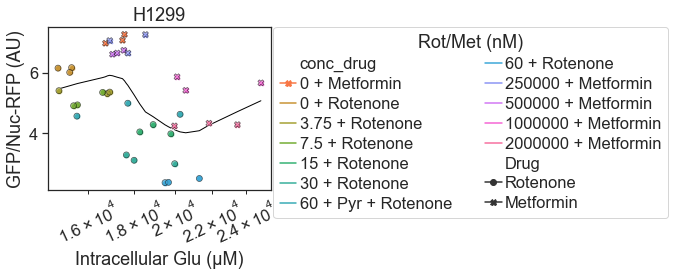

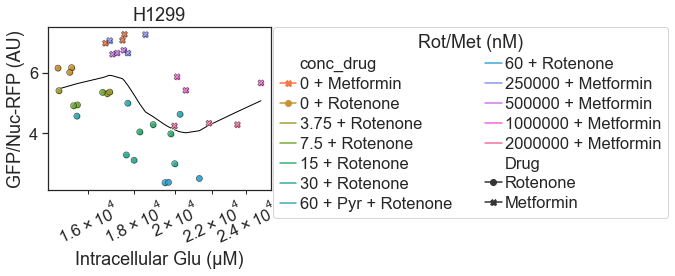

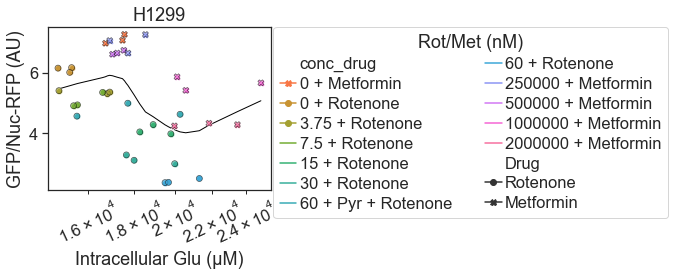

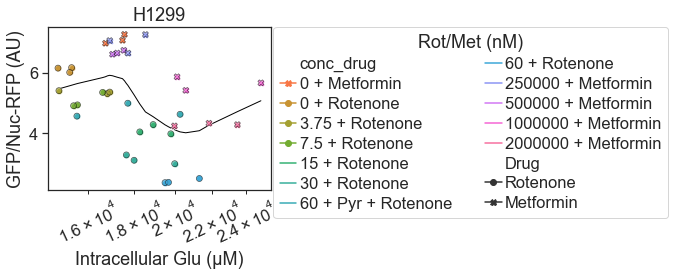

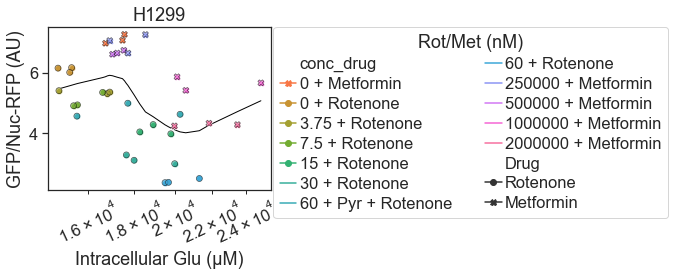

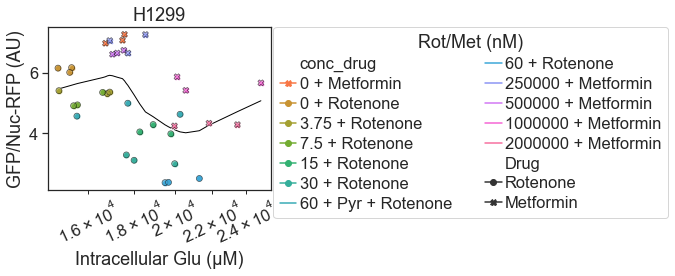

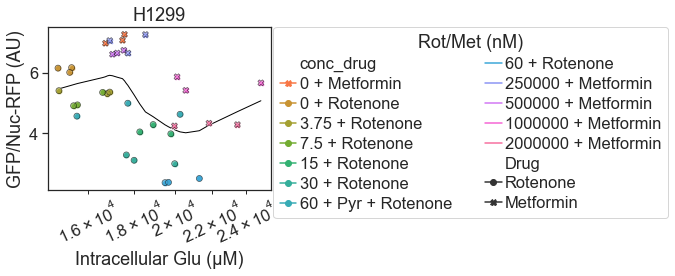

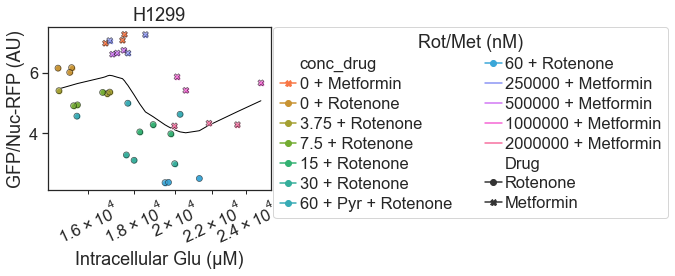

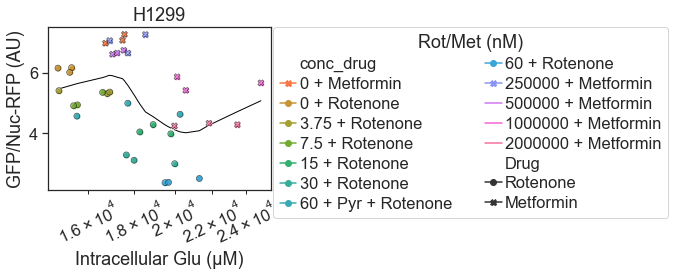

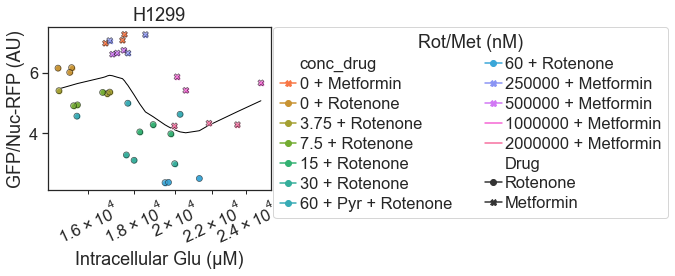

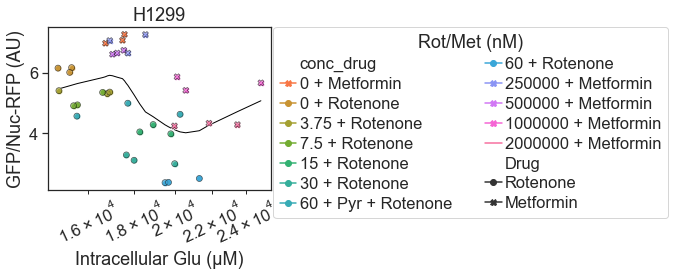

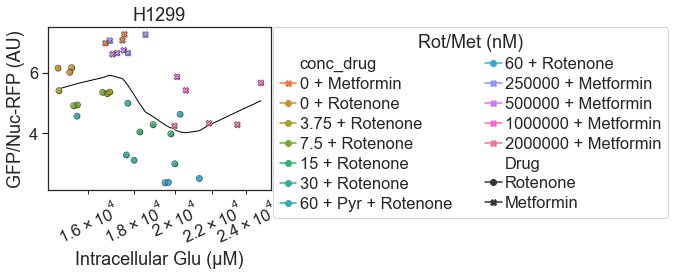

In [15]:
mask = (conc_df['Cell line'] == 'H1299 Nuc-RFP Asp-sens') & (conc_df['Drug'] != 'AOA') & (conc_df['Drug'] != 'Antimycin A')
hue_order = natsorted(conc_df.loc[mask, 'conc_drug'])
style_order = ['Rotenone', 'Metformin']

metab_list = ['Aspartate neg', 'Glutamate neg']
with PdfPages('steady-state_plots/steady-state_H1299_Nuc-RFP_Asp-sens_Asp-Glu.pdf') as pp:
    for metab in metab_list:
        metab_nam = metab.split()[0]
        
        fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))
        if metab_nam == 'Aspartate':
            y = conc_df.loc[mask, 'GFP/RFP']
            x = conc_df.loc[mask, 'Aspartate neg'].values
            plot_sigmoid(x, y, ax1, max_top=max(y)*1.2)
        else:
            g1 = sns.regplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, lowess=True, scatter_kws=dict(alpha=0), line_kws=dict(color='black', linewidth=1))

        g2 = sns.lineplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, hue='conc_drug', \
                             hue_order=hue_order, zorder=10, alpha=0.6, \
                             legend=True, markers=True, style='Drug', style_order=style_order, \
                             ls='none', dashes=False);
        g3 = sns.scatterplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, hue='conc_drug', \
                             hue_order=hue_order, zorder=10, edgecolor='black', linewidth=0.7, alpha=0.6, \
                             legend=False, markers=True, style='Drug', style_order=style_order);

        g2.set_xscale('log', base=10)
        ax1.set_xscale('log', base=10)
        g2.set_ylabel('GFP/Nuc-RFP (AU)')
        g2.set_xlabel('Intracellular {} (µM)'.format(metab_nam[0:3]))
        g2.set_title('H1299')
        #g2.set_xticklabels(g1.get_xticklabels(), rotation=90, size=12)

        sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=2, \
                        alignment='center', labelspacing=0.3, handletextpad=0.2, borderaxespad=0, \
                        handlelength=1, title='Rot/Met (nM)')

        if metab_nam == 'Glutamate':
            ax1.tick_params(axis='x', which="both", bottom=True, labelrotation=25)

        if True:
            rot_lh, rot_lt = [], []
            met_lh, met_lt = [], []
            for lh in ax1.legend_.legendHandles:
                l_txt = lh.get_label().split(' + ')
                if len(l_txt) == 1:
                    continue
                elif len(l_txt) == 3:
                    l_txt = [l_txt[0]+' + '+l_txt[1], l_txt[2]]
                if 'Rotenone' in l_txt[1]:
                    lh.set_marker('o')
                    rot_lh.append(copy.deepcopy(lh))
                    rot_lt.append(l_txt[0])
                elif 'Metformin' in l_txt[1]:
                    lh.set_marker('X')
                    met_lh.append(copy.deepcopy(lh))
                    met_conc = str(int(l_txt[0])/1e6)
                    met_lt.append(met_conc)

            l1 = ax1.legend(rot_lh, rot_lt, loc='upper left', bbox_to_anchor=(1.04, 1), frameon=False, ncol=1, \
                            alignment='center', labelspacing=0.3, handletextpad=0.7, borderaxespad=0, \
                            handlelength=0, title='Rot (nM)', fontsize=12, title_fontsize=15)
            l2 = ax1.legend(met_lh, met_lt, loc='upper left', bbox_to_anchor=(1.37, 1), frameon=False, ncol=1, \
                            alignment='center', labelspacing=0.3, handletextpad=0.7, borderaxespad=0, \
                            handlelength=0, title='Met (mM)', fontsize=12, title_fontsize=15)
            ax1.add_artist(l1)
        
        pp.savefig(fig, bbox_inches='tight')
        # plt.close(fig)

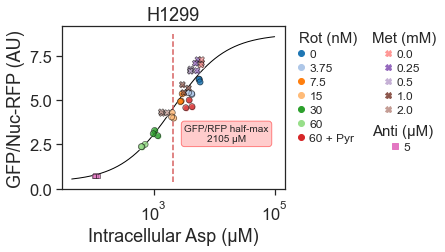

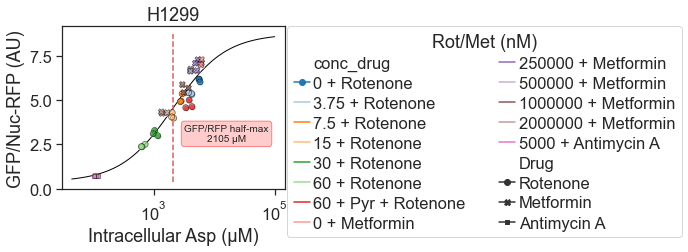

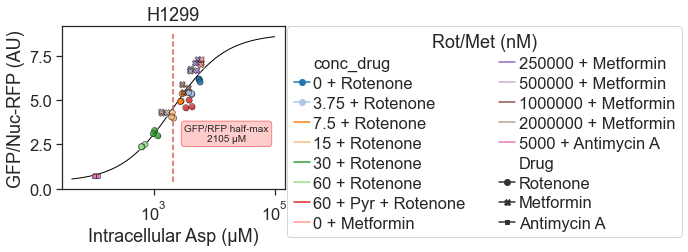

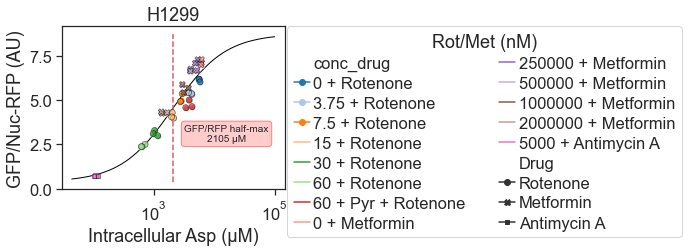

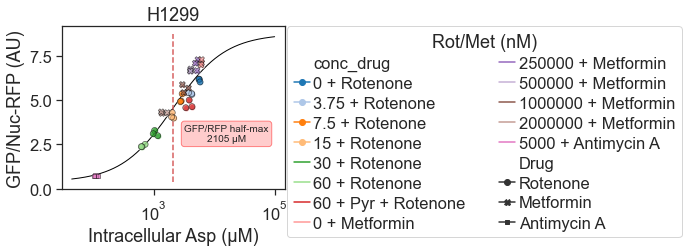

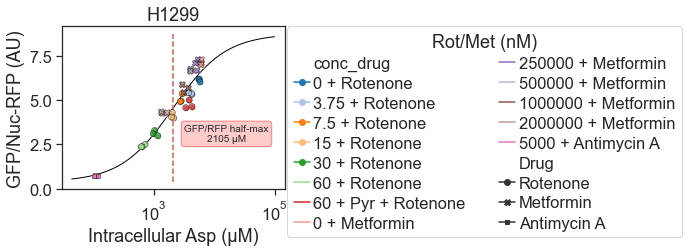

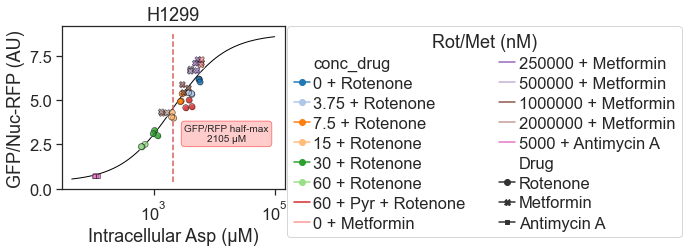

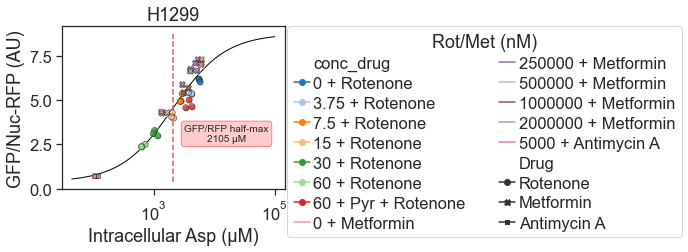

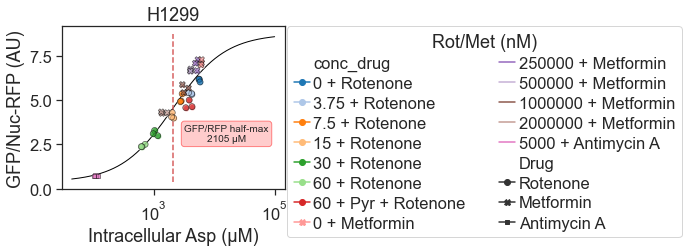

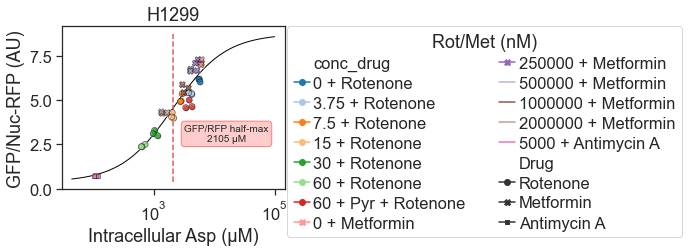

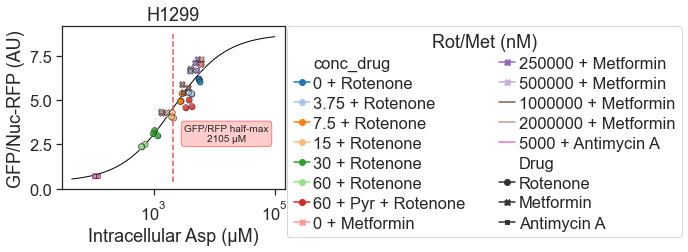

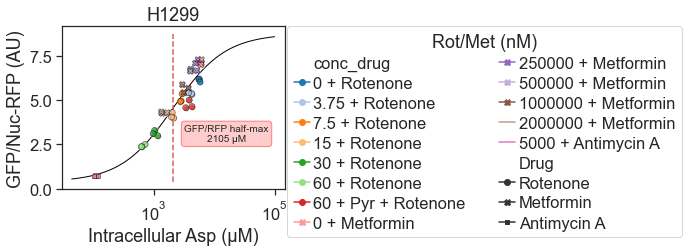

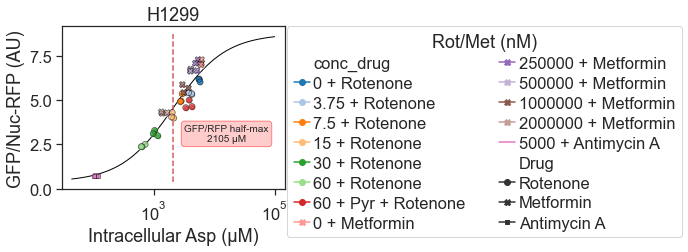

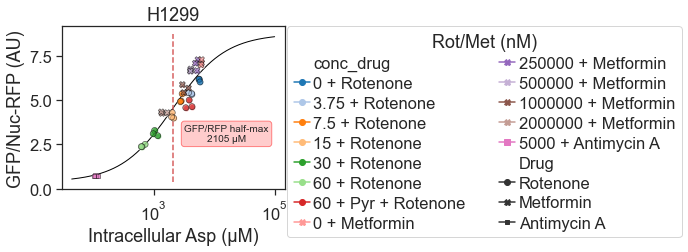

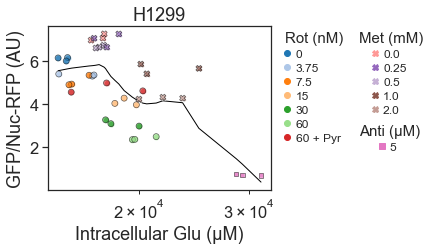

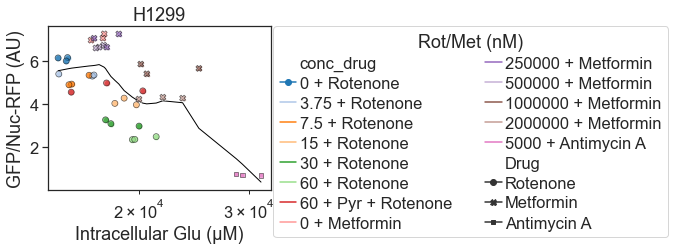

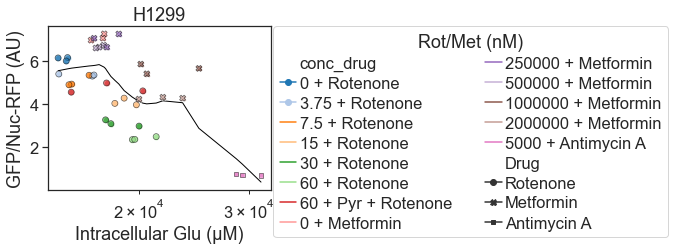

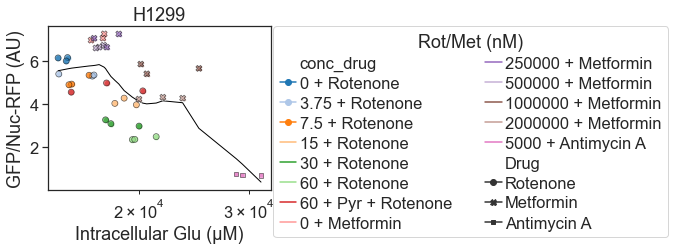

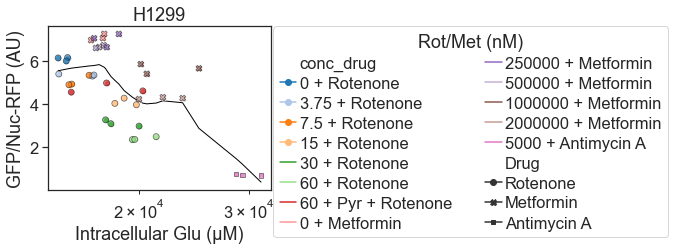

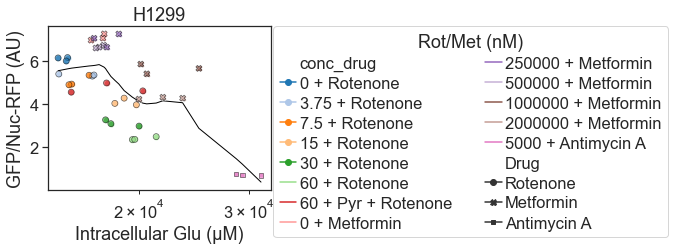

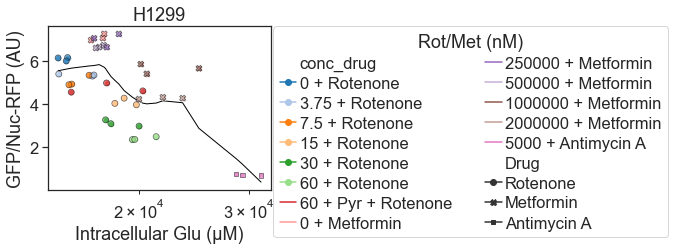

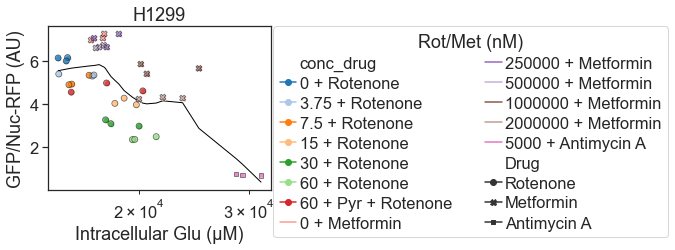

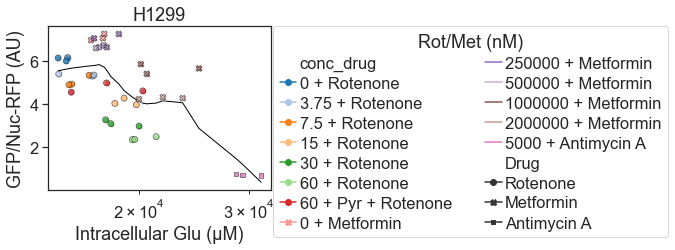

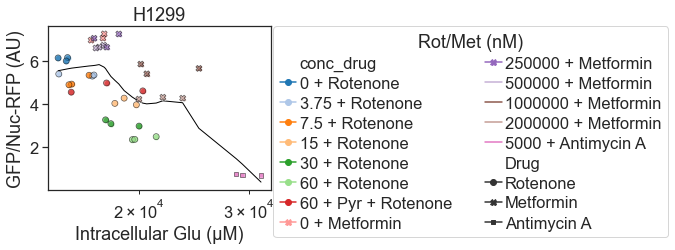

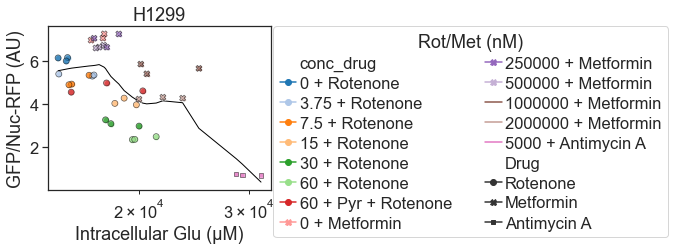

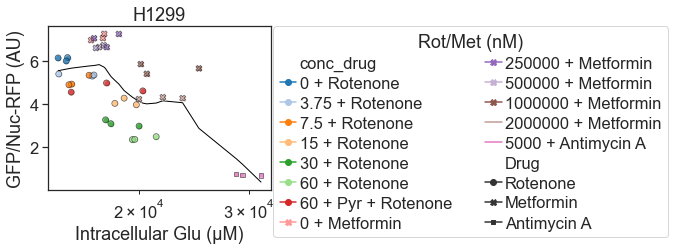

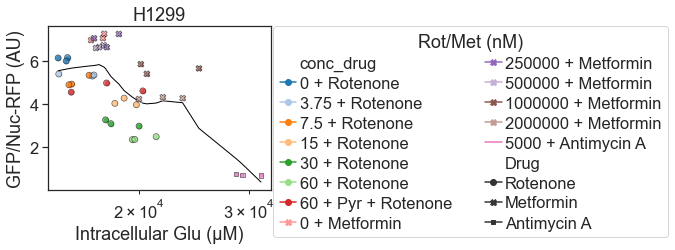

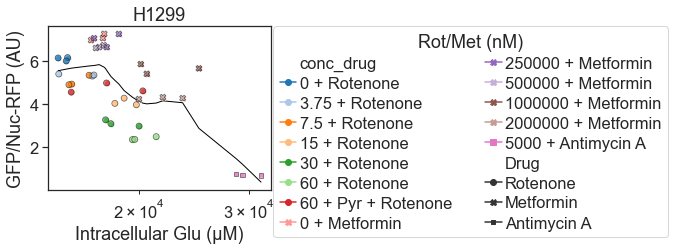

In [16]:
mask = (conc_df['Cell line'] == 'H1299 Nuc-RFP Asp-sens') & (conc_df['Drug'] != 'AOA') #& (conc_df['Drug'] != 'Antimycin A')
# hue_order = natsorted(conc_df.loc[mask, 'conc_drug'])
hue_order = ['0 + Rotenone',
 '3.75 + Rotenone',
 '7.5 + Rotenone',
 '15 + Rotenone',
 '30 + Rotenone',
 '60 + Rotenone',
 '60 + Pyr + Rotenone',
 '0 + Metformin',
 '250000 + Metformin',
 '500000 + Metformin',
 '1000000 + Metformin',
 '2000000 + Metformin',
 '5000 + Antimycin A']
style_order = ['Rotenone', 'Metformin', 'Antimycin A']

metab_list = ['Aspartate neg', 'Glutamate neg']
with PdfPages('steady-state_plots/steady-state_H1299_Nuc-RFP_Asp-sens_Asp-Glu_Anti.pdf') as pp:
    for metab in metab_list:
        metab_nam = metab.split()[0]
        
        fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))
        if metab_nam == 'Aspartate':
            y = conc_df.loc[mask, 'GFP/RFP']
            x = conc_df.loc[mask, 'Aspartate neg'].values
            plot_sigmoid(x, y, ax1, max_top=max(y)*1.2, percentile=(2, 98))
        else:
            g1 = sns.regplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, lowess=True, scatter_kws=dict(alpha=0), line_kws=dict(color='black', linewidth=1))

        g2 = sns.lineplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, hue='conc_drug', \
                             hue_order=hue_order, zorder=10, alpha=0.6, \
                             legend=True, markers=True, style='Drug', style_order=style_order, \
                             ls='none', dashes=False, palette='tab20');
        g3 = sns.scatterplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, hue='conc_drug', \
                             hue_order=hue_order, zorder=10, edgecolor='black', linewidth=0.7, alpha=0.6, \
                             legend=False, markers=True, style='Drug', style_order=style_order, palette='tab20');

        g2.set_xscale('log', base=10)
        g2.set_ylabel('GFP/Nuc-RFP (AU)')
        g2.set_xlabel('Intracellular {} (µM)'.format(metab_nam[0:3]))
        g2.set_title('H1299')
        #g2.set_xticklabels(g1.get_xticklabels(), rotation=90, size=12)

        sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=2, \
                        alignment='center', labelspacing=0.3, handletextpad=0.2, borderaxespad=0, \
                        handlelength=1, title='Rot/Met (nM)')

        if True:
            rot_lh, rot_lt = [], []
            met_lh, met_lt = [], []
            anti_lh, anti_lt = [], []
            for lh in ax1.legend_.legendHandles:
                l_txt = lh.get_label().split(' + ')
                if len(l_txt) == 1:
                    continue
                elif len(l_txt) == 3:
                    l_txt = [l_txt[0]+' + '+l_txt[1], l_txt[2]]
                if 'Rotenone' in l_txt[1]:
                    lh.set_marker('o')
                    rot_lh.append(copy.deepcopy(lh))
                    rot_lt.append(l_txt[0])
                elif 'Metformin' in l_txt[1]:
                    lh.set_marker('X')
                    met_lh.append(copy.deepcopy(lh))
                    met_conc = str(int(l_txt[0])/1e6)
                    met_lt.append(met_conc)
                elif 'Antimycin A' in l_txt[1]:
                    lh.set_marker('s')
                    anti_lh.append(copy.deepcopy(lh))
                    anti_conc = str(int(int(l_txt[0])/1e3))
                    anti_lt.append(anti_conc)
                    
            l1 = ax1.legend(rot_lh, rot_lt, loc='upper left', bbox_to_anchor=(1.04, 1), frameon=False, ncol=1, \
                            alignment='center', labelspacing=0.3, handletextpad=0.7, borderaxespad=0, \
                            handlelength=0, title='Rot (nM)', fontsize=12, title_fontsize=15)
            l2 = ax1.legend(met_lh, met_lt, loc='upper left', bbox_to_anchor=(1.37, 1), frameon=False, ncol=1, \
                            alignment='center', labelspacing=0.3, handletextpad=0.7, borderaxespad=0, \
                            handlelength=0, title='Met (mM)', fontsize=12, title_fontsize=15)
            l3 = ax1.legend(anti_lh, anti_lt, loc='upper left', bbox_to_anchor=(1.37, 0.43), frameon=False, ncol=1, \
                            alignment='center', labelspacing=0.3, handletextpad=0.7, borderaxespad=0, \
                            handlelength=0, title='Anti (µM)', fontsize=12, title_fontsize=15)
            ax1.add_artist(l1)
            ax1.add_artist(l2)
        
        pp.savefig(fig, bbox_inches='tight')
        # plt.close(fig)

### Plots for H1299 GOT DKO

In [17]:
mask = conc_df['Cell line'] == 'H1299 GOT-DKO Nuc-RFP Asp-sens'
plot_order = natsorted(conc_df.loc[mask, 'conc_res'])

metab_list = ['Aspartate neg', 'Asparagine pos', 'Glutamate neg', 'Glutamine pos']
with PdfPages('steady-state_plots/steady-state_H1299-GOT-DKO_Nuc-RFP_Asp-sens.pdf') as pp:
    for metab in metab_list:
        metab_nam = metab.split()[0]
        fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))
        
        
        if metab_nam == 'Aspartate':
            y = conc_df.loc[mask, 'GFP/RFP']
            x = conc_df.loc[mask, 'Aspartate neg'].values
            plot_sigmoid(x, y, ax1, max_top=max(y)*1.2)
        else: 
            g1 = sns.regplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, lowess=True, scatter_kws=dict(alpha=0))
        
        g2 = sns.scatterplot(ax=ax1, data=conc_df[mask], y='GFP/RFP', x=metab, hue='conc_res', zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, legend=True);
        g2.set_xscale('log', base=10)
        g2.set_ylabel('GFP/RFP (AU)')
        g2.set_xlabel('{} (µM)'.format(metab_nam))
        g2.set_title('H1299 GOT DKO Nuc-RFP Asp-sens')
        #g2.set_xticklabels(g1.get_xticklabels(), rotation=90, size=12)
        sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                        alignment='center', labelspacing=0.3, handletextpad=0.2, borderaxespad=0, \
                        handlelength=1, title='Media Asp (nM)')

        ax1.tick_params(which="both", bottom=True, labelrotation=25)
        pp.savefig(fig, bbox_inches='tight')
        plt.close(fig)